# PHB granule microscopy data analysis
Zach Flinkstrom - 02Feb2023

In [2]:
#import useful packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats

## Analyze High resource enrichment image data from ImageJ output files
Since they contained appreciable PHB and lipid membrane staining was effective for determining approximate cell area

In [3]:
def calc_percent(df):
    #Converts image area data into volumes based on a sphere of the same cross sectional area, and into masses based on conversion factors from Lazic et al
    df['Volume'] = 4/3*df['Area']**1.5/np.pi**0.5
    df['PHB_Volume'] = 4/3*(df['Area']*df['%Area']/100)**1.5/np.pi**0.5
    df['PHB_%_Volume'] = df['PHB_Volume']*100/df['Volume']
    df['PHB_%_Mass'] = 100*(df['PHB_Volume']*1.22)/(df['PHB_Volume']*1.22+(df['Volume']-df['PHB_Volume'])*1.11)
    return df

In [4]:
#Process each data file into one big dataframe
high_data = pd.DataFrame(columns=['sample', 'file', 'PHB_%_Mass'])
for subdir, dirs, files in os.walk('data-high-phb'):
    for file in files:
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(subdir,file))
            df = calc_percent(df)
            high_data = high_data.append(pd.DataFrame(zip(np.repeat(subdir.split('/')[1], len(df.index)), np.repeat(file.split('.')[0], len(df.index)),
                                                df['PHB_%_Mass']), columns=['sample','file','PHB_%_Mass']))    
high_data['PHB_present'] = high_data['PHB_%_Mass'] > 0 #add column for boolean PHB detected or not
high_data.head()

,sample,file,PHB_%_Mass,PHB_present
0,High-1,Snap-20610,1.520869,True
1,High-1,Snap-20610,4.417651,True
2,High-1,Snap-20610,0.474473,True
3,High-1,Snap-20610,3.208957,True
4,High-1,Snap-20610,6.348639,True


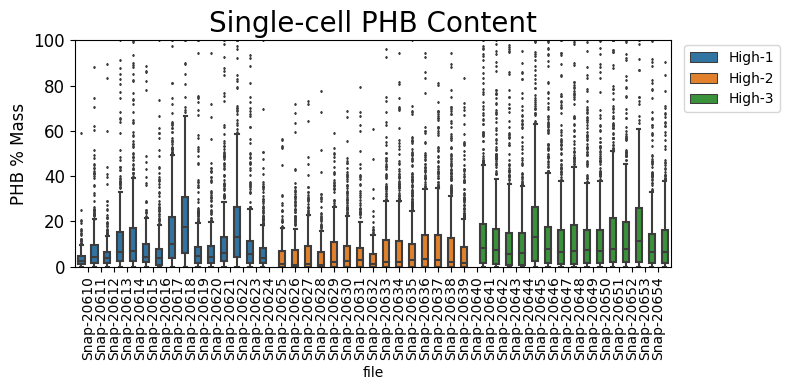

In [5]:
#Plots data from each file individually
plt.figure(figsize=(8,4))
sns.boxplot(data=high_data, y='PHB_%_Mass', x='file', hue='sample', width=1.5, fliersize=1.0)
plt.xticks(rotation=90)
plt.title('Single-cell PHB Content', size=20)
plt.ylabel("PHB % Mass", size=12)
plt.yticks(size=12)
plt.ylim([0,100])
plt.xlim([-1, 45])
plt.legend(bbox_to_anchor=(1.01, 1.01))
plt.tight_layout()
plt.savefig('figures/single_cell_phb_per_file.png', dpi=300)
plt.show()

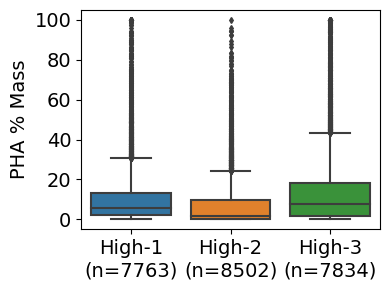

In [6]:
#Plots single cell distribution of PHB for each culture
#Annotates the mean PHB percent and the number of cells counted
plt.figure(figsize=(4,3))
sns.boxplot(data=high_data, x='sample', y='PHB_%_Mass', fliersize=3.0)
#plt.title('Single-cell PHA Content', size=20)
plt.ylabel("PHA % Mass", size=14)
plt.xticks([0,1,2], labels=['High-1\n(n=7763)','High-2\n(n=8502)','High-3\n(n=7834)'], size=14)
plt.xlabel('')
plt.yticks(size=14)
#plt.text(0.05,50, 'Mean = \n {:.2f}%'.format(high_data.groupby('sample').mean().loc['High-1'][0]), size=12)
#plt.text(0.05,65, 'n = {:.0f}'.format(high_data.groupby('sample').count().loc['High-1'][0]), size=12)

#plt.text(1.05,50, 'Mean = \n {:.2f}%'.format(high_data.groupby('sample').mean().loc['High-2'][0]), size=12)
#plt.text(1.05,65, 'n = {:.0f}'.format(high_data.groupby('sample').count().loc['High-2'][0]), size=12)

#plt.text(2.05,50, 'Mean = \n {:.2f}%'.format(high_data.groupby('sample').mean().loc['High-3'][0]), size=12)
#plt.text(2.05,65, 'n = {:.0f}'.format(high_data.groupby('sample').count().loc['High-3'][0]), size=12)

plt.tight_layout()
plt.savefig('figures/single_cell_phb_per_sample_v3.png', dpi=300)
plt.show()

In [9]:
#Mean PHB%mass for high enrichments
print('Overall PHB %mass for high resource enrichments:')
high_data.groupby('sample').mean()['PHB_%_Mass'].mean()

Overall PHB %mass for high resource enrichments:


10.683219077435316

In [10]:
high_data.groupby('sample').mean()

,PHB_%_Mass,PHB_present
sample,,
High-1,10.637692,0.892567
High-2,7.226473,0.634909
High-3,14.185492,0.826142


In [11]:
high_data.groupby('sample').std()

,PHB_%_Mass,PHB_present
sample,,
High-1,14.464059,0.309683
High-2,11.939446,0.481484
High-3,18.740468,0.379011


In [12]:
#Standard deviation of PHB%Mass between 3 high enrichments
high_data.groupby('sample').mean()['PHB_%_Mass'].std()

3.4797325720682886

In [13]:
high_data.to_csv('output/high_enrichment_single_cell_data.csv')

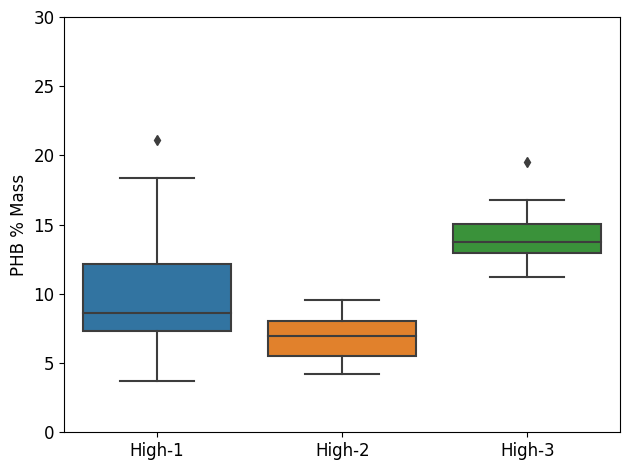

In [14]:
#Plots the per image average of PHB content (15 images taken for each culture)
sns.boxplot(data=pd.DataFrame(high_data.groupby(['sample','file']).mean()).reset_index(), x='sample', y='PHB_%_Mass')
#plt.title("Per Image Mean PHB Content", size=20)
plt.ylim([0,30])
plt.ylabel("PHB % Mass", size=12)
plt.xticks(size=12)
plt.xlabel('')
plt.yticks(size=12)
plt.tight_layout()
plt.savefig('figures/mean_phb_per_image_v2.png', dpi=300)
plt.show()

In [15]:
#Import Sybr green cell counts for the high nutrient cultures
high_sybr = pd.DataFrame(columns=['Slice', 'Count', 'Total Area', 'Average Size', '%Area', 'Mean', 'sample'])
for subdir, dirs, files in os.walk('data-high-sybr'):
    for file in files:
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(subdir,file))
            df['sample'] = subdir.split('/')[1]
            high_sybr = high_sybr.append(df)
high_sybr['file'] = high_sybr['Slice'].str.split('.', expand=True)[0]
high_sybr.head()

,Slice,Count,Total Area,Average Size,%Area,Mean,sample,file
0,Snap-20610.czi - C=0,466,224.182,0.481,0.244,255,High-1,Snap-20610
0,Snap-20611.czi - C=0,896,548.461,0.612,0.598,255,High-1,Snap-20611
0,Snap-20612.czi - C=0,667,427.558,0.641,0.466,255,High-1,Snap-20612
0,Snap-20613.czi - C=0,1024,1019.188,0.995,1.111,255,High-1,Snap-20613
0,Snap-20614.czi - C=0,1594,1516.269,0.951,1.653,255,High-1,Snap-20614


In [16]:
#Merge the sybr green cell counts with the PHB quantification data
high_merge = pd.DataFrame(high_data.groupby(['sample','file'])['PHB_present'].sum())
high_merge = high_merge.merge(high_sybr, how='left', on='file')
high_merge['%cells'] = 100*high_merge['PHB_present']/high_merge['Count'] #PHB+ cells / total sybr green cell count
high_merge.head()

,file,PHB_present,Slice,Count,Total Area,Average Size,%Area,Mean,sample,%cells
0,Snap-20610,251,Snap-20610.czi - C=0,466,224.182,0.481,0.244,255,High-1,53.862661
1,Snap-20611,399,Snap-20611.czi - C=0,896,548.461,0.612,0.598,255,High-1,44.53125
2,Snap-20612,314,Snap-20612.czi - C=0,667,427.558,0.641,0.466,255,High-1,47.076462
3,Snap-20613,431,Snap-20613.czi - C=0,1024,1019.188,0.995,1.111,255,High-1,42.089844
4,Snap-20614,628,Snap-20614.czi - C=0,1594,1516.269,0.951,1.653,255,High-1,39.397742


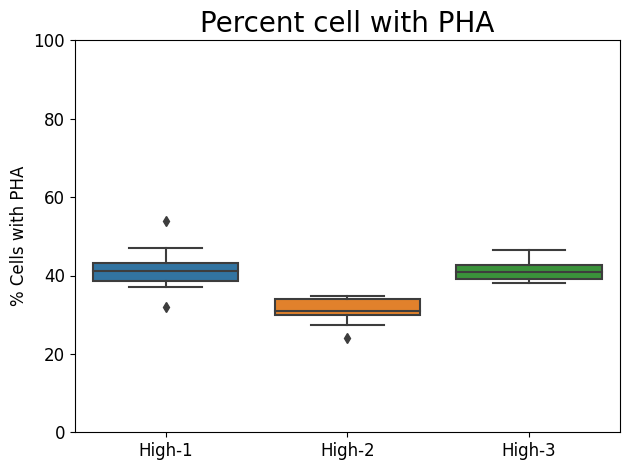

In [17]:
#Plot just high enrichment Percent cells with PHB
sns.boxplot(data=high_merge, x='sample', y='%cells')
plt.title("Percent cell with PHA", size=20)
plt.ylim([0,100])
plt.ylabel("% Cells with PHA", size=12)
plt.xticks(size=12)
plt.xlabel('')
plt.yticks(size=12)
plt.tight_layout()

## Analyze Low Resource Culture Image data from ImageJ output files
Need alternative pipeline using Sybr green because the membrane staining was not prominent.\
Use Sybr green and PHB particle count for rough approximateion of % cells positive for PHB

In [18]:
#Process each data file into one big dataframe
low_data1 = pd.DataFrame(columns=['Slice', 'Count', 'Total Area', 'Average Size', '%Area', 'Mean', 'sample'])
for subdir, dirs, files in os.walk('data-low'):
    for file in files:
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(subdir,file))
            df['sample'] = subdir.split('/')[1]
            low_data1 = low_data1.append(df)   

low_data1['snap'] = low_data1['Slice'].str.split(expand=True)[0]
low_data1['channel'] = low_data1['Slice'].str.split(expand=True)[2]
low_data1

,Slice,Count,Total Area,Average Size,%Area,Mean,sample,snap,channel
0,Snap-20655.czi - C=1,0,0,NaN,0,NaN,Low-1,Snap-20655.czi,C=1
0,Snap-20655.czi - C=0,172,164.495,0.956,0.445,255,Low-1,Snap-20655.czi,C=0
0,Snap-20656.czi - C=1,0,0,NaN,0,NaN,Low-1,Snap-20656.czi,C=1
0,Snap-20656.czi - C=0,74,96.13,1.299,0.26,255,Low-1,Snap-20656.czi,C=0
0,Snap-20657.czi - C=1,1,0.746,0.746,0.002,255,Low-1,Snap-20657.czi,C=1
...,...,...,...,...,...,...,...,...,...
0,Snap-20697.czi - C=0,676,716.704,1.060,1.938,255,Low-3,Snap-20697.czi,C=0
0,Snap-20698.czi - C=1,6,7.746,1.291,0.021,255,Low-3,Snap-20698.czi,C=1
0,Snap-20698.czi - C=0,268,242.635,0.905,0.656,255,Low-3,Snap-20698.czi,C=0
0,Snap-20699.czi - C=1,3,2.355,0.785,0.006,255,Low-3,Snap-20699.czi,C=1


In [19]:
#Combine information from Sybr and PHB channels into one frame
low_data = pd.DataFrame(columns=['sample', 'snap', 'sybr_count', 'sybr_area', 'phb_count', 'phb_area'])
for snap in list(set(low_data1.snap)):
    subset = low_data1[low_data1.snap == snap]
    temp = pd.DataFrame([subset[subset.channel == 'C=0']['sample'][0], 
                         snap,
                         subset[subset.channel == 'C=0']['Count'][0], 
                         subset[subset.channel == 'C=0']['Total Area'][0],
                         subset[subset.channel == 'C=1']['Count'][0], 
                         subset[subset.channel == 'C=1']['Total Area'][0]]).T
    temp.columns = ['sample', 'snap', 'sybr_count', 'sybr_area', 'phb_count', 'phb_area']
    low_data = low_data.append(temp)

In [20]:
low_data['%cells'] = 100*low_data['phb_count']/low_data['sybr_count']
low_data['%area'] = 100*low_data['phb_area']/low_data['sybr_area']
low_data.head()

,sample,snap,sybr_count,sybr_area,phb_count,phb_area,%cells,%area
0,Low-2,Snap-20681.czi,173,145.091,5,6.437,2.890173,4.436526
0,Low-2,Snap-20679.czi,312,409.485,1,0.471,0.320513,0.115023
0,Low-2,Snap-20677.czi,415,345.124,3,1.112,0.722892,0.322203
0,Low-3,Snap-20688.czi,414,308.213,6,4.396,1.449275,1.426286
0,Low-3,Snap-20699.czi,362,285.119,3,2.355,0.828729,0.825971


In [21]:
#combine high and low enrichment data for plotting
high_low = high_merge[['sample','%cells']].append(low_data[['sample','%cells']])

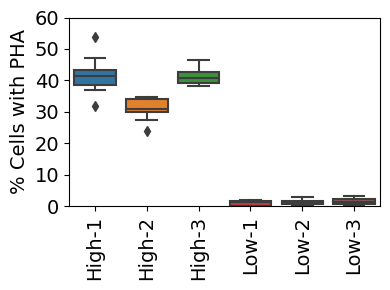

In [22]:
#Plot the Percent cells with PHB
plt.figure(figsize=(4,3))
sns.boxplot(data=high_low.sort_values('sample'), x='sample', y='%cells')
#plt.title("Percent of Cells with PHA", size=20)
plt.ylim([0,60])
plt.ylabel("% Cells with PHA", size=14)
plt.xticks(size=14, rotation=90)
plt.xlabel('')
plt.yticks(size=14)
plt.tight_layout()
plt.savefig('figures/Percent_cells_with_PHB_high_low_v3.png', dpi=300)
plt.show()

In [23]:
#Mean Percent cells with PHB
high_low.groupby('sample').mean()

,%cells
sample,
High-1,41.439397
High-2,31.025814
High-3,41.104196
Low-1,0.995673
Low-2,1.400018
Low-3,1.527118


In [24]:
#Standard deviation of Percent cells with PHB
high_low.groupby('sample').std()

,%cells
sample,
High-1,4.987132
High-2,3.101243
High-3,2.577380
Low-1,0.790786
Low-2,0.839188
Low-3,0.972142


In [25]:
print("High enrichment mean percent cells with PHA = ")
print(high_low.groupby('sample').mean()[0:3].mean())
print("+/-")
print(high_low.groupby('sample').mean()[0:3].std())

High enrichment mean percent cells with PHA = 
%cells    37.856469
dtype: float64
+/-
%cells    5.917895
dtype: float64


In [26]:
print("Low enrichment mean percent cells with PHA = ")
print(high_low.groupby('sample').mean()[3:6].mean())
print("+/-")
print(high_low.groupby('sample').mean()[3:6].std())

Low enrichment mean percent cells with PHA = 
%cells    1.307603
dtype: float64
+/-
%cells    0.277514
dtype: float64


In [27]:
#GC %PHB data
gc_data = [13.47, 9.27, 14.95]
print("mean gc data:")
print(np.mean(gc_data))
print("std gc data:")
print(np.std(gc_data))

mean gc data:
12.563333333333333
std gc data:
2.405844734992034


In [28]:
high_low.to_csv('output/high_and_low_percent_with_PHB.csv')